# Report task 3: Compare my model to Google's model

## Introduction

The purpose of this report is to compare some techniques to create Machine Learning models. 

In this file you will find some code written in comments. This is code that is only necessary to run on Streamlit. The version on Streamlit will have that code not in comments. 

Streamlit link:  

## Scraping for images

First of all, I need images so that I can train our Deep Learning model. This needs a lot of images (100+) and the more images gathered, the better the model is trained. 

In [ ]:
import fastbook
fastbook.setup_book()
import os
from fastbook import *

Next we need our different categories we want to train the model for. I have chosen to characters in Star Wars. So the goal of our algorithm is to tell which character there is on an image. For structure, i create a folders. The main "images" folder and there are folders for each category.

In [68]:
categories=["Darth Vader", "Yoda", "Luke Skywalker", "R2D2", "C3PO"]
data_dir="./images/"
def setup_directories(categories):
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    for category in categories:
        directory_path = data_dir+category.replace(" ", "_")
        print(directory_path)
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)

setup_directories(categories)

./images/Darth_Vader
./images/Yoda
./images/Luke_Skywalker
./images/R2D2
./images/C3PO


I have chosen not to create a regular web scraper to get images. I use fastbook, with this module i can connect to some API's, the API i am sending requests to is the DuckDuckGo images API. After some testing I have noticed that with regular web scrapers, the program quits after a set amount of images. For Google this was 20 and for Bing this was 35. If i wanted to gather 100+ images per category, i would have to make multiple web scrapers, so this seemed as the better option.

First i loop through the categories to gain 150 results. I have chosen 150 images, because I have noticed that not all the images can be downloaded this way. That's why I've chosen a number bigger than 100 and after executing the program I also have more than 100 images left.

After that I loop through all the image links and I send a get request to get the image. I check for errors and also for if the response status is 200. I save the image in the correct folder with a unique name. I also print errors in case they happen.

In [ ]:
def get_images(categories):

    for category in categories:
        # Search on DuckDuckGo for images of current category
        results = search_images_ddg(category, max_images=150)
        save_and_check_image(category=category, results=results)

def save_and_check_image(category, results):
    #setup directory path to save images, each category has it's own directory
    directory_path = data_dir+category.replace(" ", "_")
    category_name = category.replace(" ","")

    # number of correctly downloaded image
    img_number=1

    #loop through all links and catch errors that may occur
    for index, link in enumerate(results):
        try:
            # get the images
            response = requests.get(link, timeout=10)

            # Check if the request was successful 
            if response.status_code == 200:

                # Get file extension and check if they are a correct image extension
                file_extension = link.split('.')[-1]
                if file_extension in ["jpeg", "jpg", "png"]:

                    # Save the image to a file with img_number as a identifier
                    filename = f"{category_name}_duckduckgo_{img_number}.{file_extension}"
                    filepath = os.path.join(directory_path, filename)
                    
                    with open(filepath, 'wb') as file:
                        for chunk in response.iter_content(chunk_size=128):
                            file.write(chunk)
                
                    
                    print(f"Image {index + 1} downloaded: {filename}")
                    img_number+=1
            else:
                print(f"Invalid response status for image {index+1}: {response.status_code}")
        except Exception as e:
            print(f"Error downloading image {index+1}: {str(e)}")
            continue

get_images(categories)

Now the dataset for our program is complete.

## EDA & Prep the data

### EDA

Here I show how many images there are for each category. After that I use MatPlotLb to show some of the images.

In [41]:
import matplotlib.pyplot as plt

Category: Darth Vader, Number of Images: 118
Category: Yoda, Number of Images: 139
Category: Luke Skywalker, Number of Images: 111
Category: R2D2, Number of Images: 108
Category: C3PO, Number of Images: 108


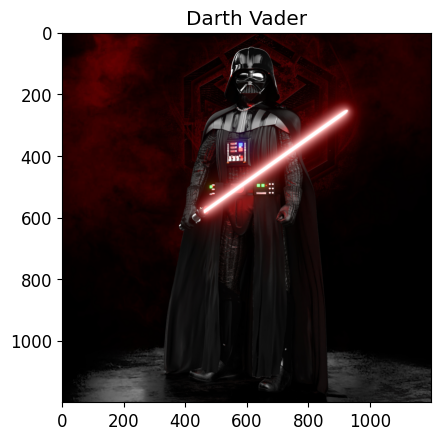

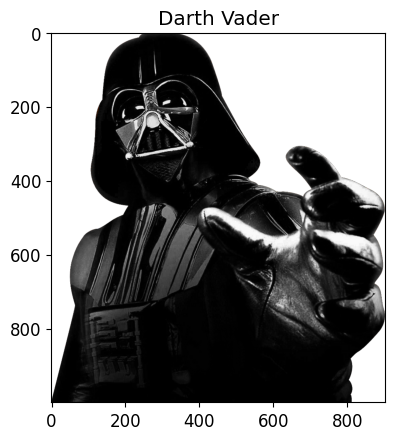

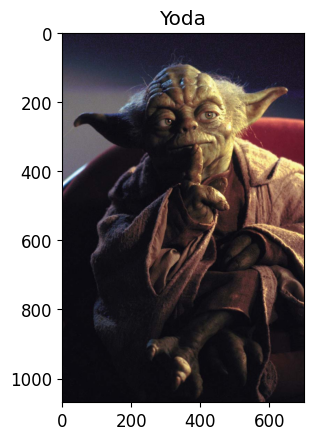

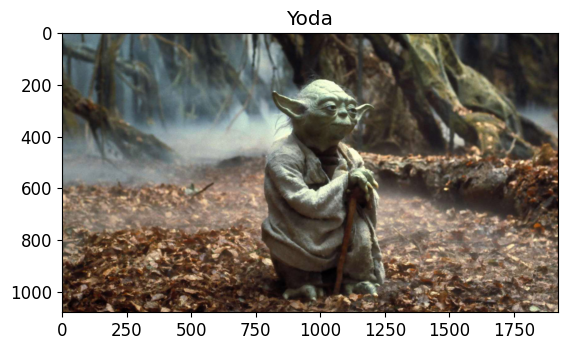

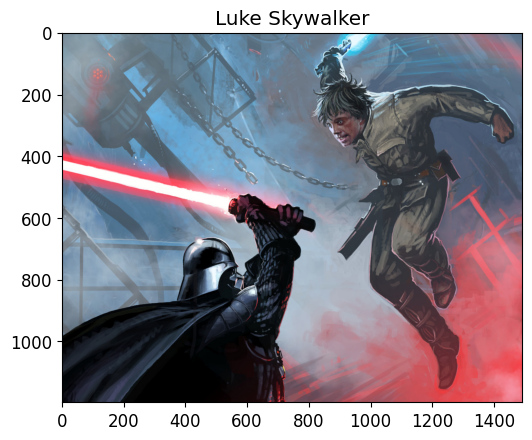

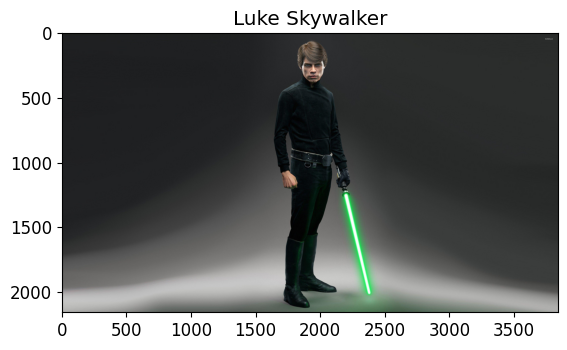

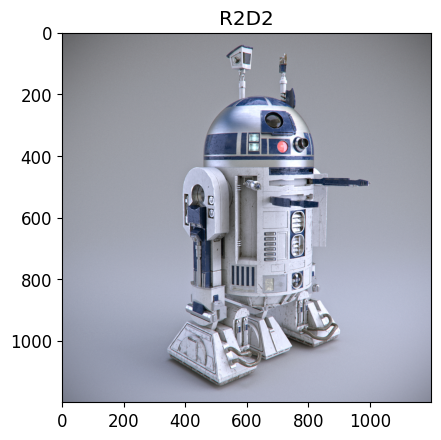

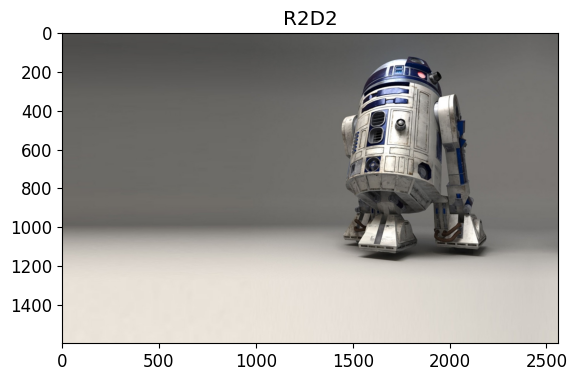

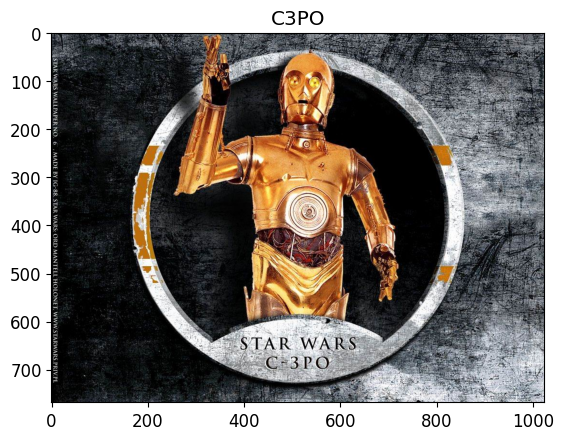

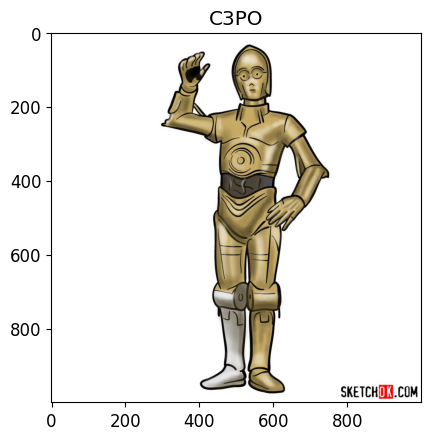

In [69]:
def count_images(categories):
    lowest_total = 100000
    directories= []
    for category in categories:
        category_path = os.path.join(data_dir, category.replace(" ", "_"))
        num_images = len(os.listdir(category_path))
        print(f"Category: {category}, Number of Images: {num_images}")

        lowest_total = min(lowest_total, num_images)
        directories.append(category_path)

    display_random_images(categories)

def display_random_images(categories, amount_category_images=2):
    for category in categories:
        category_name = category.replace(" ","_")
        #/{category_name}", category.replace(" ", "")
        category_path = os.path.join(data_dir, category_name)
        image_files = os.listdir(category_path)[:amount_category_images]  # Displaying the first 5 images
        for image_file in image_files:
            image_path = os.path.join(category_path, image_file)
            image = Image.open(image_path)
            plt.imshow(image)
            plt.title(category)
            plt.show()
    

count_images(categories)

### Prep the data

The images are in directories according to their category, not according to training and testing dataset. So instead of using flow_from_directory, we can use flow_from_dataframe (ImageDataGenerator, z.d.).

In [80]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

def create_data_sets():
    # Create empty lists to store file paths and corresponding labels
    file_paths = []
    labels = []

    # Populate the lists with file paths and labels
    for category in os.listdir(data_dir):
        category_path = os.path.join(data_dir, category)
        image_files = os.listdir(category_path)
        for image_file in image_files:
            file_paths.append(os.path.join(category_path, image_file))
            labels.append(category)

    #    Split the data into training and testing sets
    train_file_paths, test_file_paths, train_labels, test_labels = train_test_split(
        file_paths, labels, test_size=0.1, random_state=42, stratify=labels
    )

    # Create DataFrames from the lists
    train_df = pd.DataFrame({'filename': train_file_paths, 'label': train_labels})
    test_df = pd.DataFrame({'filename': test_file_paths, 'label': test_labels})

    # Data augmentation and normalization for training
    train_val_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    #Data normalization
    test_datagen = ImageDataGenerator(rescale = 1./255)

        # Flow training images in batches using train_datagen generator
    training_set = train_val_datagen.flow_from_dataframe(
        train_df,
        subset='training',
        x_col='filename',
        y_col='label',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical'
    )


    validation_set = train_val_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='label',
        subset='validation',
        target_size = (64, 64),
        batch_size = 32,
        class_mode = 'categorical'
    )   



# Flow testing images in batches using test_datagen generator
    test_set = test_datagen.flow_from_dataframe(
        test_df,
        x_col='filename',
        y_col='label',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical'
    )
    return training_set, test_set, validation_set
training_set, test_set, validation_set = create_data_sets()

Found 420 validated image filenames belonging to 5 classes.


Found 105 validated image filenames belonging to 5 classes.
Found 59 validated image filenames belonging to 5 classes.


In [79]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Set the number of classes
NUM_CLASSES = 1

# Create a sequential model with a list of layers
model = models.Sequential([
    layers.Conv2D(64, (3, 3), input_shape=(64, 64, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x000002004D792340>

In [76]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import layers

In [77]:
NUM_CLASSES = 1

# Create a sequential model with a list of layers
model = tf.keras.Sequential([
  layers.Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation="relu", padding="same"),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.2),
  layers.Conv2D(32, (3, 3), activation="relu"),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation="relu"),
  layers.Dense(NUM_CLASSES, activation="sigmoid") # because it's one class, we use sigmoid
])

# Compile and train your model as usual
model.compile(optimizer = optimizers.Adam(learning_rate=0.001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 15, 15, 32)       

In [78]:
history = model.fit(training_set,
                validation_data = validation_set,
                steps_per_epoch = 10,
                epochs = 20
                )

c:\Users\rafen\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x000002004C4F0D10>

## Literatuurlijst

ImageDataGenerator. (z.d.). tensorflow. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe

### Convolution